# Optimise the graph matching parameters for protein secondary structure contact map alignment

# import

In [1]:
import numpy as np
import pandas as pd
import networkx as nx 
import scipy as sp
import matplotlib.patches as patches

In [2]:
from module.PGMD import SSE_read, pair_PGMD

from module.DME import DMatchEval


/Users/ssm47/opt/anaconda3/envs/thesis_env/lib/python3.9/site-packages/graspologic/layouts/colors.py:13: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/ssm47/opt/anaconda3/envs/thesis_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from module.sse_matching_master_draft import *

## init params:

In [ ]:
save_things = False

# data

In [5]:
# from full scop database:
fpath = '../../data/proteins/scop-cla-latest.txt'

with open(fpath) as f:
    lines = f.readlines()




In [6]:
headers = lines[5].strip('#').strip('\n').split(' ')[1:]

scop_df = pd.DataFrame([l.strip('\n').split(' ') for l in lines[6:]], columns=headers)



In [7]:
scop_df

,FA-DOMID,FA-PDBID,FA-PDBREG,FA-UNIID,FA-UNIREG,SF-DOMID,SF-PDBID,SF-PDBREG,SF-UNIID,SF-UNIREG,SCOPCLA
0,8000061,2DT5,A:2-77,Q5SHS3,2-77,8001519,2DT5,A:4-63,Q5SHS3,4-63,"TP=1,CL=1000003,CF=2000144,SF=3000034,FA=4000057"
1,8000376,2FR0,A:1448-1915,Q03131,1395-1862,8000377,2FR0,A:1657-1915,Q03131,1604-1862,"TP=1,CL=1000002,CF=2000148,SF=3000038,FA=4000119"
2,8000693,1UDC,A:1-338,P09147,1-338,8000694,1UDC,A:1-263,P09147,1-263,"TP=1,CL=1000002,CF=2000148,SF=3000038,FA=4000088"
3,8000768,2PWZ,A:1-312,P61889,1-312,8000769,2PWZ,A:1-312,P61889,1-312,"TP=1,CL=1000002,CF=2000005,SF=3000039,FA=4000045"
4,8000794,1MG5,A:1-255,P00334,2-256,8001233,1MG5,A:1-240,P00334,2-241,"TP=1,CL=1000002,CF=2000148,SF=3000038,FA=4000029"
...,...,...,...,...,...,...,...,...,...,...,...
36895,8018581,3THX,B:217-1120,P20585,226-1129,8056712,3THX,B:357-507,P20585,366-516,"TP=1,CL=1000002,CF=2001251,SF=3000587,FA=4004015"
36896,8018581,3THX,B:217-1120,P20585,226-1129,8056714,3THX,B:845-1053,P20585,854-1062,"TP=1,CL=1000002,CF=2001251,SF=3002020,FA=4004015"
36897,8018583,2O8B,B:362-1335,P52701,362-1335,8056718,2O8B,B:423-487,P52701,423-487,"TP=1,CL=1000002,CF=2001251,SF=3001688,FA=4004015"
36898,8018583,2O8B,B:362-1335,P52701,362-1335,8056719,2O8B,B:537-697,P52701,537-697,"TP=1,CL=1000002,CF=2001251,SF=3000587,FA=4004015"


In [8]:

scopcla_col = [eval('dict(' + i + ')') for i in scop_df.SCOPCLA.values]
scopcla_df = pd.DataFrame(scopcla_col)

In [9]:
name_key = dict(TP='type', CL='class', CF='fold', SF='superfamily', FA='family')

In [10]:
scopcla_df.rename(columns=name_key)

,type,class,fold,superfamily,family
0,1,1000003,2000144,3000034,4000057
1,1,1000002,2000148,3000038,4000119
2,1,1000002,2000148,3000038,4000088
3,1,1000002,2000005,3000039,4000045
4,1,1000002,2000148,3000038,4000029
...,...,...,...,...,...
36895,1,1000002,2001251,3000587,4004015
36896,1,1000002,2001251,3002020,4004015
36897,1,1000002,2001251,3001688,4004015
36898,1,1000002,2001251,3000587,4004015


TP=protein type, CL=protein class, CF=fold, SF=superfamily, FA=family

- **type**: four groups; soluble, membrane, fibrous and intrinsically disordered.
- **class**: 5 structural classes; all-alpha and all-beta proteins, containing predominantly alpha-helices and beta-strands, respectively, and ‘mixed’ alpha and beta classes (a/b) and (a+b) with respectively alternating and segregated alphahelices and beta-strands, and the fifth class of small proteins with little or no secondary structures. 
- **family**: closely related proteins with a clear evidence for their evolutionary origin.
- **superfamily**: groups together more distantly related protein domains.
- **fold**: global structural features shared by the majority of consitutent superfamily members. Some families with same superfamily can belong to different folds. 




In [11]:
scop_df['FA-PDBREG_a'] = scop_df['FA-PDBREG'].str.split(':').apply(lambda x:x[0])
scop_df['p_id'] = scop_df['FA-PDBID'].str.lower() +'_' + scop_df['FA-PDBREG_a'] 
scopcla_df['p_id'] = scop_df['p_id']

In [12]:
class_sample = scopcla_df.groupby('CL').sample(random_state=9)
sample_pid = class_sample.p_id.values

In [13]:
sampled_trials = scopcla_df[scopcla_df['FA'].isin(class_sample.FA.values)].groupby(['CL', 'FA']).sample(2, random_state=0).groupby(['CL', 'FA']).p_id.apply(list).values

In [14]:
np.hstack(sampled_trials)

array(['5c0z_A', '7c90_A', '6wu9_X', '6osk_W', '1wv9_B', '2fsx_A',
       '6mj9_A', '1jat_A', '2o13_A', '1x64_A'], dtype='<U6')

In [15]:
# known pairs
fpath = '../../data/proteins/pairs.txt'
known_pairs = pd.read_csv(fpath,delimiter = "\t").to_numpy()

In [16]:
# domains

fpath = '../../data/proteins/SCOP_domain.txt'
with open(fpath) as f:
    lines = f.readlines()
splt = [i.split() for i in lines]
dashcount = [i.count("-") for i in lines]

domain_data = []

for row, ndash in zip(splt, dashcount):
    dms = int(ndash/3)
    for dno in range(dms):
        domain_data.append({'d_id':row[0], 'p_id':row[1], 'pdb_mb':row[2 + (dno)],\
                             'r_idx':row[2+dms + dno], 'sse_idx':row[2+(2*dms) + dno],\
                             'domain':row[(3+(3*dms)):], 'dno':dno})
domain_data=pd.DataFrame(domain_data)

domain_dict = domain_data.groupby('d_id').p_id.apply(set).to_dict()

nonsingle_domain_dict = {key:val for key, val in domain_dict.items() if len(val)>1}

nonsingle_domains = list(nonsingle_domain_dict.keys())


In [17]:
fpath = '../../data/proteins/scop_sse_range.txt'
scop_ranges = pd.read_csv(fpath, delimiter='\t', header=None)
scop_ranges.columns = ['d_id', 'p_id', 'idx_range']

In [18]:
scop_ranges.d_id = scop_ranges.d_id.astype(str)

In [19]:
fpath = '../../data/proteins/filter_scop.txt'
scop_rf = pd.read_csv(fpath, delimiter='\t', header=None)
scop_rf.columns = ['p_id', 'seq']

In [ ]:
larger_proteins = scop_rf[scop_rf.seq.apply(len) > scop_rf.seq.apply(len).median()].p_id.values

smaller_proteins = scop_rf[scop_rf.seq.apply(len) < scop_rf.seq.apply(len).median()].p_id.values

In [ ]:
# rfiltered_pids = np.stack(scop_rf.p_id.str.upper().str.split('_').apply(np.array).values)

rfiltered_pids = scop_rf.p_id.values

In [ ]:
scop_rf_df = scop_df[scop_df['p_id'].isin(rfiltered_pids)]

In [ ]:
rf_p_ids = list(set(scop_ranges.p_id) & set(scop_rf.p_id)) # proteins in both redundancy filtered and scop index range files (from Runfeng)...!

In [ ]:
print(len(rf_p_ids)) 

print(len(set(rf_p_ids) & set(scop_df.p_id)))

24172
24172


In [ ]:
scopcla_df_rf = scopcla_df.query('p_id.isin(@rf_p_ids)')

In [ ]:
grouped_ser = scopcla_df_rf.query('CL!=1000004').query('p_id.isin(@larger_proteins)').groupby(['CL', 'FA']).p_id.apply(set).apply(len).sort_values()

In [ ]:
large_class_sample = grouped_ser[grouped_ser > 1].reset_index().groupby('CL').sample(random_state=0)

In [ ]:
# sampled_trials = scopcla_df_rf[scopcla_df_rf['FA'].isin(class_sample.FA.values)].groupby(['CL', 'FA']).sample(2, random_state=0).groupby(['CL', 'FA']).p_id.apply(list).values

sampled_trials = scopcla_df_rf[scopcla_df_rf['FA'].isin(large_class_sample.FA.values)].groupby(['CL', 'FA']).sample(2, random_state=0).groupby(['CL', 'FA']).p_id.apply(list).values

In [ ]:
np.hstack(sampled_trials)

array(['1o17_D', '1brw_A', '5g5d_A', '6xx1_A', '1hl9_B', '4psr_B',
       '1zet_A', '5kfn_A'], dtype='<U6')

In [ ]:
range_dict = scop_ranges[scop_ranges.p_id.isin(np.hstack(sampled_trials))].set_index('p_id').idx_range.to_dict()


In [ ]:
filtered_scop_ranges = scop_ranges.query('p_id.isin(@rf_p_ids)')

# Param optimization for domain assignments using simulated annealing:

In [33]:
pairpathpf = f'../../data/proteins/100_sec_map/sscm'
pairopathpf = '../../data/proteins/100_sec_map/orientation'


In [34]:
def exponential_schedule(t):
    """Exponential decay schedule."""
    initial_temp = 10
    cooling_rate = 0.99
    return initial_temp * (cooling_rate**t)


def prep_random_state(seed):
    np.random.seed(seed) # seed the random numbers...
    def random_state(state):
        update = np.random.normal(loc=0, scale=0.3, size=len(state))
        new = state + update
        return new
    return random_state



def prep_eval_func(id_1_idxrange, id_2_idxrange):
    def func(perm_inds):
        # l_1 = len(perm_inds)
        # l_a = len(id_1_idxrange)
        # l_b = len(id_2_idxrange)

        id_1_idx_extended = np.arange(id_1_idxrange[0], min([len(perm_inds), id_1_idxrange[0] + len(id_2_idxrange)]))
        
        mse = (perm_inds[id_1_idx_extended] - id_1_idx_extended)**2
        return mse, id_1_idx_extended
    return func

def prep_objective(id_1, id_2, eval_func=None, th=7.5, sim_func=invd_sim_func, fpathprefix=pairpathpf,opathprefix=pairopathpf):
    def objective(param):
        val, alpha, gamma = param
        sse_inst = SSE_read(fpathprefix=fpathprefix, 
                    opathprefix=opathprefix, 
                    fpathext='txt', 
                    opathext='txt', 
                    chainval=val, 
                    sim_func=sim_func, 
                    chain_func=forward_chain_adj_prep, 
                    threshold=th)

        pgmd_inst = pair_PGMD(assembly_func=sse_inst.assemble_strict) 
        run_gm_output = pgmd_inst.run_gm(pids=[id_1, id_2], alpha=alpha, gamma=gamma, use_lengths=True, match_args=None)
        g2_to_g1_node_mapping = run_gm_output['node_mapping']
        perm_inds = run_gm_output['perm_inds']
        ids = pgmd_inst.sorted_ids
        structure_names = [i + '_structure' for i in ids]
        # the following supposes that the domain lies from the zeroeth index onwards...
        # Calculate the mean squared error of the matching of indices, with a penalty from mismatching SSE types. 
        if eval_func==None:
            proposed = np.arange(len(perm_inds))
            mse = (proposed - perm_inds)**2 # mean squared error from linear assumption
            sse_typematch_bool = (~(g2_to_g1_node_mapping.dropna()[structure_names[0]].apply(lambda x: x[0]) == g2_to_g1_node_mapping.dropna()[structure_names[1]].apply(lambda x: x[0]))).values
            mismatch_penalty = sum(sse_typematch_bool)*(len(g2_to_g1_node_mapping)**2)
            objval = sum(mse[~sse_typematch_bool]) + mismatch_penalty

        else:
            mse, id_1_idx_extended = eval_func(perm_inds)
            sse_typematch_bool = (~(g2_to_g1_node_mapping.dropna()[structure_names[0]].apply(lambda x: x[0]) == g2_to_g1_node_mapping.dropna()[structure_names[1]].apply(lambda x: x[0]))).values
            mismatch_penalty = sum(sse_typematch_bool)*(len(g2_to_g1_node_mapping)**2)
            objval = sum(mse[~sse_typematch_bool[id_1_idx_extended]]) + mismatch_penalty


        return objval
    return objective




In [35]:
val, alpha, gamma =1.2 , 4.2, np.sqrt(2) #  0.43630615, 9.55751756, 0.12000447

sim_func =  invd_sim_func
p=2
th=7.5
type_to_tex_dict = {'E':r'$\blacksquare$', 'H':r'$\bigcirc$'}
sdict = {'E':'s', 'H':'o'}


In [36]:
to_test = {} # only those that start from zero

for d_id in nonsingle_domains:
    dslice = domain_data[domain_data['d_id']==d_id]
    dindices = dslice.sse_idx.tolist()
    startfromzero = [i[0]=='0' for i in dindices]    
    to_test[d_id] = set(dslice.p_id[startfromzero])
nonsingle_intro = [key for key, val in to_test.items() if len(val)>0]

In [37]:
to_test = {} # only those that start from zero

for d_id in nonsingle_domains:
    dslice = domain_data[domain_data['d_id']==d_id]
    dindices = dslice.sse_idx.tolist()
    startfromzero = [i[0]=='0' for i in dindices]    
    to_test[d_id] = set(dslice.p_id[startfromzero])
nonsingle_intro = [key for key, val in to_test.items() if len(val)>0]
# ind_domain = list(set(nonsingle_domain_dict.get(nonsingle_domains[ind])))

inds = [7,8]
ind_domain = [[i[:-1] + '_A' for i in list(to_test.get(nonsingle_intro[ind]))] for ind in inds]

# ind_domain = [i[:-1] + '_A' for i in ind_domain]


In [38]:
d_ids = [nonsingle_intro[i] for i in inds]

In [39]:
dom_df = scop_ranges.query('d_id.isin(@d_ids)')

In [40]:
dom_df

,d_id,p_id,idx_range
3703,4000121,1ger_A,0-37
3704,4000121,1onf_A,0-34
3705,4000121,1lvl_A,0-41
3706,4000121,1lpf_A,0-40
3707,4000121,1xdi_A,0-38
3708,4000121,1m6i_A,0-45
3709,4000121,1h6v_A,0-38
3710,4000121,1q1r_A,0-40
3711,4000121,3lad_A,0-38
3712,4000121,1v59_A,0-37


In [41]:
dom_df.groupby('d_id')[['p_id', 'idx_range']].apply(lambda x: [x.p_id, x.idx_range])

d_id
4000121    [[1ger_A, 1onf_A, 1lvl_A, 1lpf_A, 1xdi_A, 1m6i...
4000123    [[1pn0_C, 2vou_A, 3c96_A, 1iut_A, 1pbe_A], [0-...
dtype: object

In [42]:
p_ids_dict = dom_df.groupby('d_id').p_id.apply(list).to_dict()

p_idxranges_dict = dom_df.groupby('d_id').idx_range.apply(list).to_dict()


In [43]:
ind_domain = dom_df[['p_id', 'idx_range']].to_numpy()
# ind_domain_ranges = dom_df.idx_range.tolist()

In [ ]:
def get_contact_matrix(pid, dirpath='/Users/ssm47/Library/CloudStorage/OneDrive-UniversityofCambridge/ssnw', suffix=None):
    '''Updated contact matrix getting from directory, and the full sse chain including coils.'''
    if suffix==None:
        suffix='txt'
    fpath = dirpath + '/'+ f'{pid}.{suffix}'
    data = pd.read_csv(fpath, delimiter = "\t")
    # data = pd.read_csv(fpath, index_col=0)

    cmat = data.iloc[1:, 2:].dropna(axis=0, how='all').dropna(axis=1, how='all')

    lengths = data.Length[cmat.index.values].to_numpy()
    ele_inds = data.iloc[:,1][cmat.index.values].to_numpy()
    cmat.reset_index(drop=True, inplace=True)
    # print(cmat)
    cmat.columns = cmat.index.values    
    new_indices = []
    for ele, length in zip(ele_inds, lengths):
        new_indices.append(ele[0] + str(int(length)))

    cmat.insert(loc=0, column='ss_ele', value=new_indices)
    cmat.replace(to_replace='-', value=np.inf, inplace=True)


    full_lengths = data.Length[1:].to_list()
    full_ssetypes = data.iloc[:,1][1:].to_list()
    full_sses = []

    for ele, length in zip(full_ssetypes, full_lengths):
        full_sses.append(ele[0] + str(int(length)))
    cmat.set_index('ss_ele', inplace=True)
    cmat = cmat.apply(pd.to_numeric)
    return cmat, full_sses


In [45]:
# trials = []

# for d_id, dom in p_ids_dict.items():
#     psizes= {}
#     for i, pid in enumerate(dom):
#         shape = get_contact_matrix(pid=pid, dirpath='../../data/proteins/ssnw')[0].shape
#         psizes[pid] = shape
#     sorted_inds = sorted(list(zip(dom,p_idxranges_dict[d_id])), key=lambda x: psizes.get(x[0]))

#     for i in range(len(sorted_inds)):
#         for j in range(i+1, len(sorted_inds)):

#             trials.append([sorted_inds[i], sorted_inds[j]])


In [46]:
# proteins = np.hstack(list(p_ids_dict.values()))

In [47]:
# dirpath='/Users/ssm47/Library/CloudStorage/OneDrive-UniversityofCambridge/ssnw'

# new_path = '../../data/proteins/ssnw'
# for pid in proteins:
#     fpath = dirpath + '/'+ f'{pid}.ssnw'
#     data = pd.read_csv(fpath, delimiter = "\t")
#     data.to_csv(new_path + '/'+ f'{pid}.ssnw')



In [48]:
# sample = np.hstack(sampled_trials)
# dirpath='/Users/ssm47/Library/CloudStorage/OneDrive-UniversityofCambridge/ssnw'

# for pid in sample: 
#     df = pd.read_csv(dirpath + '/sscm/' + f'{pid}.txt', delimiter='\t')
#     df.to_csv(f'../../data/proteins/100_sec_map/sscm/{pid}.txt')

#     # df = pd.read_csv(dirpath + '/orientation/' + f'{pid}.txt', delimiter='\t')
#     # df.to_csv(f'../../data/proteins/100_sec_map/orientation/{pid}.txt')
 
#     print(df.head())

In [49]:
# trials = []
# for dom in ind_domain:
#     psizes= {}
#     for pid in dom:
#         shape = get_contact_matrix(pid=pid, dirpath='../../data/proteins/ssnw', suffix='ssnw')[0].shape
#         psizes[pid] = shape
#         print(shape)
#     sorted_inds = sorted(dom, key=lambda x: psizes.get(x))

#     for i in range(len(sorted_inds)):
#         for j in range(i+1,len(sorted_inds)):
#             trials.append([sorted_inds[i], sorted_inds[j]])
            

trials = []
for ids in sampled_trials[:]:
    psizes= {}
    for pid in ids:
        shape = get_contact_matrix(pid=pid, dirpath='../../data/proteins/ssnw', suffix='ssnw')[0].shape
        psizes[pid] = shape
        print(shape)
    sorted_inds = sorted(ids, key=lambda x: psizes.get(x))
    
    range_dict = scop_ranges[scop_ranges.p_id.isin(sorted_inds)].set_index('p_id').idx_range.to_dict()
    
    for i in range(len(sorted_inds)):
        for j in range(i+1,len(sorted_inds)):
            trials.append([(sorted_inds[i], range_dict.get(sorted_inds[i])), (sorted_inds[j], range_dict.get(sorted_inds[j]))])


(25, 25)
(31, 31)
(12, 12)
(16, 16)
(32, 32)
(47, 47)
(30, 30)
(35, 35)


In [50]:
obj_list = []
state = [val, alpha, gamma] # init

for row in trials:
    # print(ids)
    ids = row[0][0], row[1][0]
    ir_1, ir_2 = row[0][1].split('-'), row[1][1].split('-') 
    eval_func = prep_eval_func(id_1_idxrange=list(range(int(ir_1[0]), int(ir_1[1]))), id_2_idxrange=list(range(int(ir_2[0]), int(ir_2[1]))))

    obj = prep_objective(id_1=ids[0], id_2=ids[1], eval_func=eval_func, th=7.5, sim_func=invd_sim_func, fpathprefix=pairpathpf,opathprefix=pairopathpf)
    # obj = prep_bin_objective(id_1=ids[0], id_2=ids[1])
    obj_list.append(obj)


In [51]:
states = []
new_objs=[]

i=0
obj_value = sum([func(param=state) for func in obj_list])

best_state = state
best_value = obj_value
new_state_func = prep_random_state(seed=i)

for t in range(1000):
    Temp = exponential_schedule(t)
    if Temp <= 0:
        break
    
    new_state = new_state_func(state)
    new_obj_value = [func(param=new_state) for func in obj_list] # obj(param=new_state)
    new_obj_value = sum(new_obj_value)
    states.append(new_state)
    delta_e = new_obj_value - obj_value
    new_objs.append(new_obj_value)
    if delta_e < 0 or np.random.random() < np.exp(-delta_e / Temp):
        state = new_state
        obj_value = new_obj_value

        if obj_value < best_value:
            best_state = new_state
            best_value = new_obj_value
            print(best_value)

# ~5 mins

759
128


In [52]:
chainvals = np.array(states)[:,0]

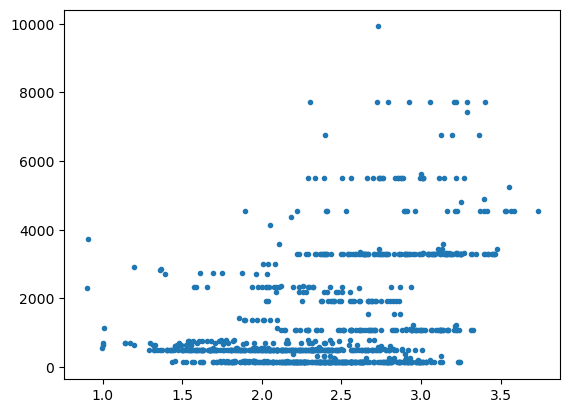

In [53]:
plt.plot(chainvals, new_objs, '.')

In [54]:
best_value

128

In [55]:
best_state # this is stochastic... do multiple times for best results!

array([2.10905126, 4.1682842 , 2.47139519])

# graph matching example:

In [56]:
chainval, alpha, gamma = 2.74349133, 7.69862416, 3.05497552 #0.733152,	2.735147,	1.681227 


In [57]:
pairpathpf = f'../../data/proteins/100_sec_map/sscm'
pairopathpf = '../../data/proteins/100_sec_map/orientation'


# initialise 
sse_inst = SSE_read(fpathprefix=pairpathpf, 
                    opathprefix=pairopathpf, 
                    fpathext='txt', 
                    opathext='txt', 
                    chainval=chainval, 
                    sim_func=invd_sim_func, 
                    chain_func=forward_chain_adj_prep, 
                    threshold=7.5)

pgmd_inst = pair_PGMD(assembly_func=sse_inst.assemble_strict) 


In [58]:
trials

[[('1o17_D', '0-3'), ('1brw_A', '22-30')],
 [('5g5d_A', '0-11'), ('6xx1_A', '0-15')],
 [('1hl9_B', '0-22'), ('4psr_B', '36-45')],
 [('1zet_A', '24-29'), ('5kfn_A', '27-34')]]

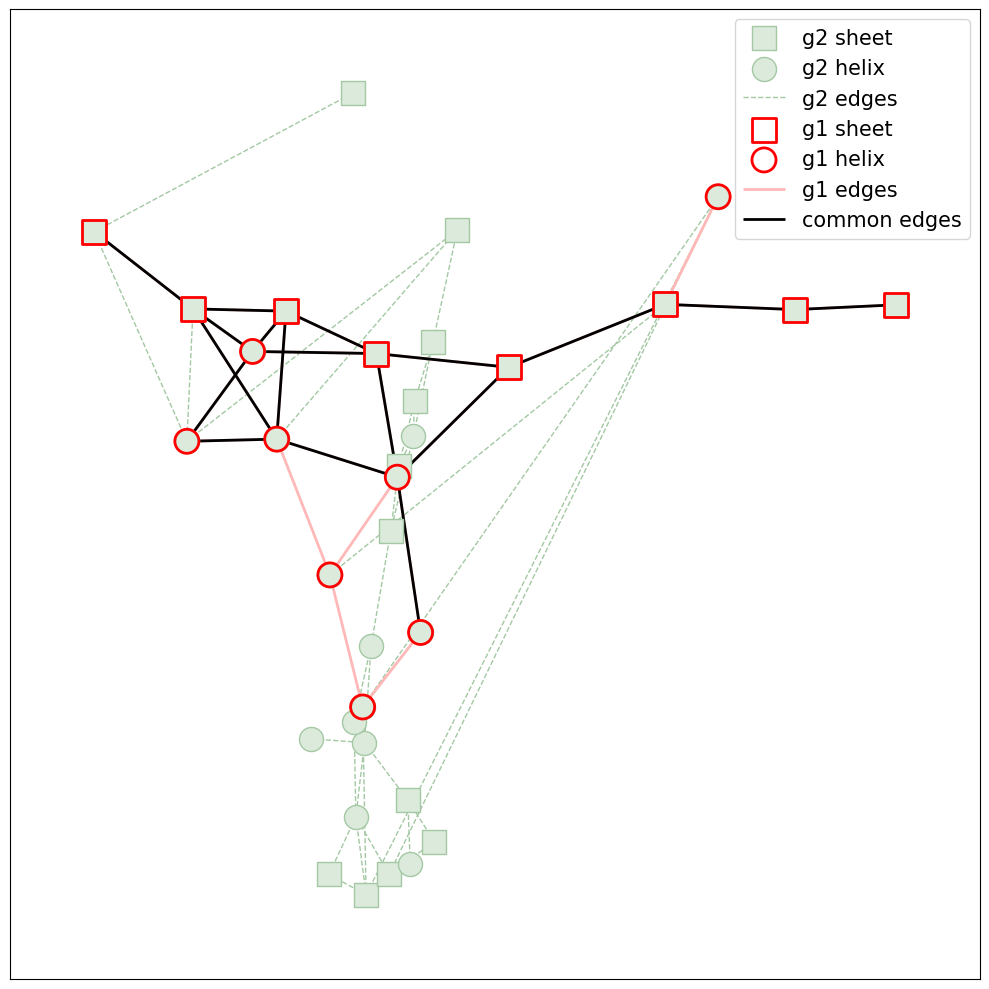

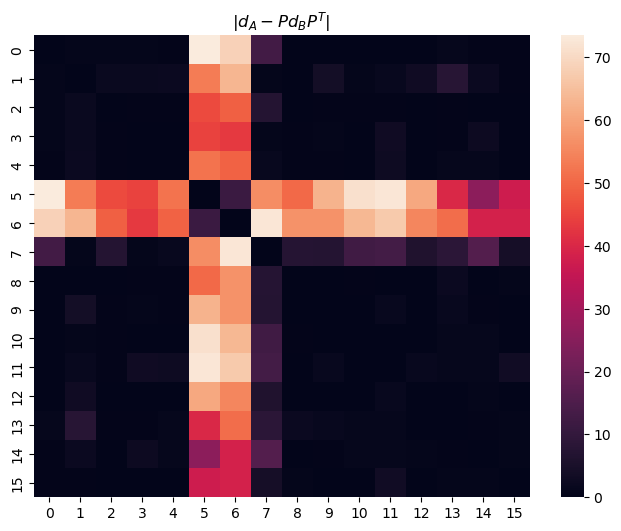

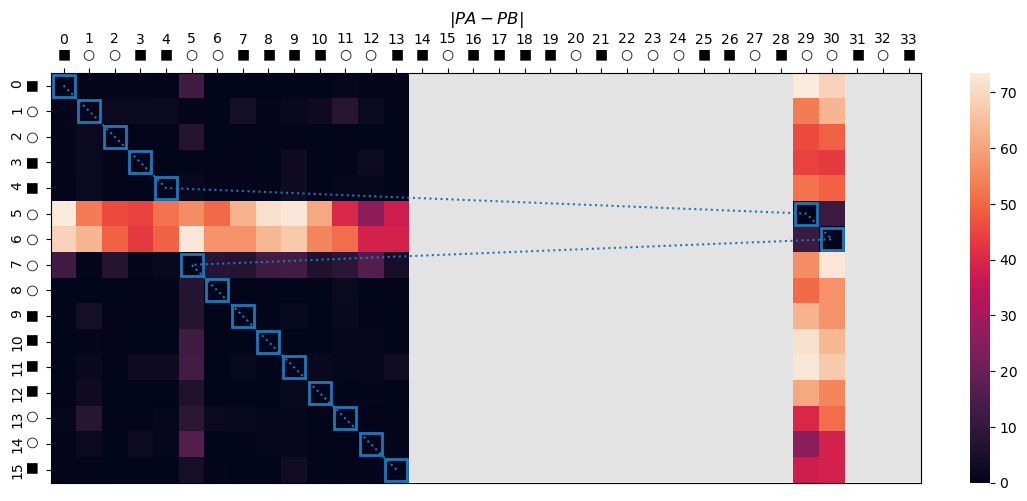

In [59]:
id_1, id_2 = '1byq_A', '5y3n_A' # trials[0]



container = pgmd_inst.get_container(pids=[id_1, id_2],)
run_gm_output = pgmd_inst.run_gm(pids=[id_1, id_2], alpha=alpha, gamma=gamma, use_lengths=True, match_args=None)
perm_inds = run_gm_output['perm_inds']
g2_to_g1_node_mapping = run_gm_output['node_mapping']

id_1, id_2 = pgmd_inst.sorted_ids # sort the ids


layoutput = pgmd_inst.get_layoutput(seed=0)
node_types_1 = {index:value[0] for index, value  in enumerate(container[0][2])}
node_types_2 = {index:value[0] for index, value  in enumerate(container[1][2])}
save_name=False
if save_things:
    save_name = f'../figures/{id_1}_{id_2}_matched_graph_vis.pdf'
draw_overlap_from_outputs(output=layoutput, domain=None, node_types_1=node_types_1, node_types_2= node_types_2, save=save_name)


colnames = g2_to_g1_node_mapping.columns
index_names = [i for i in colnames if i[-5:]=='index']
structure_names = [i.split('index')[0]+'structure' for i in index_names]
sorted_index_ser = g2_to_g1_node_mapping[index_names].count().sort_values(ascending=True)
id_index_1, id_index_2 = sorted_index_ser.index.to_numpy()
len_1, len_2 = sorted_index_ser.values

penalty = (sum(~(g2_to_g1_node_mapping.dropna()[structure_names[0]].apply(lambda x: x[0]) == g2_to_g1_node_mapping.dropna()[structure_names[1]].apply(lambda x: x[0]))))


cmat, orientation = sse_inst.set_pid(pid=id_1).prep_SSE()
adj_1 = cmat.replace([np.inf], 0).to_numpy()
sse_inst.reset_SSE()
cmat, orientation = sse_inst.set_pid(pid=id_2).prep_SSE()
adj_2 = cmat.replace([np.inf], 0).to_numpy()

diff = abs(adj_1 - adj_2[np.ix_(perm_inds, perm_inds)])

plt.figure(figsize=(8,6))
sns.heatmap(diff, annot=False, fmt=".1f")
plt.title(r'$|d_A - Pd_BP^T|$')
plt.show()

node_types_tex_2 = {str(key):str(key) + '\n' + type_to_tex_dict[val] for key, val in node_types_2.items()}
node_types_tex_1 = {str(key):str(key) + '\n' + type_to_tex_dict[val] for key, val in node_types_1.items()}

# node_types_tex_2 = {str(key):str(key) + '\n' + type_to_tex_dict[val] for key, val in node_types_2.items()}
# node_types_tex_1 = {str(key):str(key) + '\n' + type_to_tex_dict[val] for key, val in node_types_1.items()}
save_name=False
if save_things:
    save_name=f'../figures/{id_1}_{id_2}_gm.pdf'
full_diff_matrix_figure(diff=diff, g2_to_g1_node_mapping=g2_to_g1_node_mapping, node_types_tex_2=node_types_tex_2, node_types_tex_1=node_types_tex_1, save=save_name, domain=False)

# Additonal analysis:

In [60]:
varr = [i[0] for i in states]
aarr = [i[1] for i in states]
garr = [i[2] for i in states]


obj_df = pd.DataFrame({'values':[np.mean(i) for i in new_objs], \
                       'chainval':varr, 'alpha':aarr,\
                        'gamma':garr}).sort_values('values')

# obj_df

In [61]:
obj_df.sort_values('values').head(20)

,values,chainval,alpha,gamma
617,128.0,2.993851,8.345778,1.679310
83,128.0,1.571116,3.148136,2.886841
82,128.0,1.709332,3.183408,2.774905
568,128.0,2.897780,8.413465,1.752997
729,128.0,2.614407,6.975772,2.939368
518,128.0,2.805681,8.323674,3.254979
728,128.0,2.702185,6.815859,2.424540
966,128.0,2.675551,6.749348,2.655934
73,128.0,1.744782,3.387462,2.574990
721,128.0,2.783664,7.281005,2.096490


In [62]:
filtered_obj_df = obj_df[(obj_df['values']==obj_df['values'].min())&(obj_df['chainval']>0)] # 
filtered_obj_df

,values,chainval,alpha,gamma
617,128.0,2.993851,8.345778,1.679310
474,128.0,3.012764,9.805777,2.932008
250,128.0,1.982291,4.453466,3.225403
475,128.0,3.132923,10.052478,2.634157
864,128.0,2.177361,5.009989,3.440427
...,...,...,...,...
163,128.0,1.954481,4.225411,2.835817
755,128.0,2.697054,7.841148,2.892426
741,128.0,2.861799,7.988995,2.432142
164,128.0,1.914909,4.346839,2.902970


In [63]:
top_obj = obj_df[(obj_df['values']==obj_df['values'].min())] # 


In [64]:
# sns.scatterplot(top_obj, x='alpha', y='chainval')

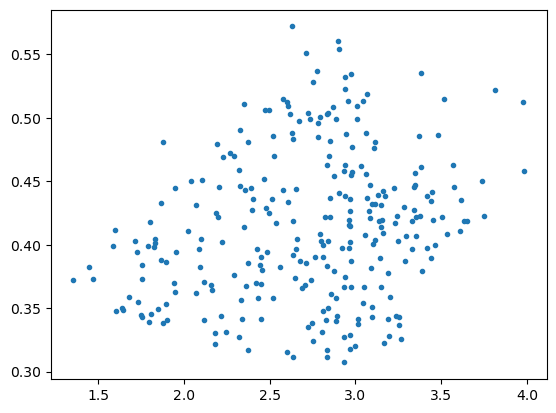

In [65]:
plt.plot(top_obj['gamma'], top_obj['chainval']/top_obj['alpha'], '.')

<Axes: xlabel='alpha', ylabel='chainval'>

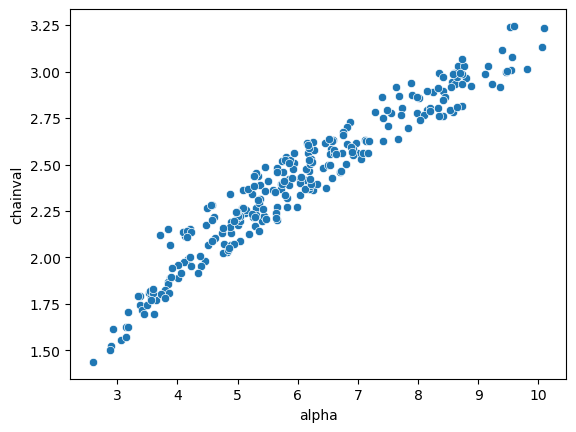

In [66]:
sns.scatterplot(top_obj, x='alpha', y='chainval')

<Axes: xlabel='gamma', ylabel='chainval'>

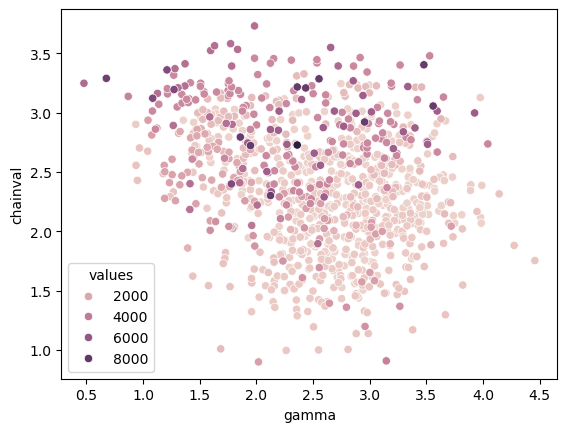

In [67]:
sns.scatterplot(obj_df, x='gamma', y='chainval', hue='values', marker='o')

<Axes: xlabel='gamma', ylabel='alpha'>

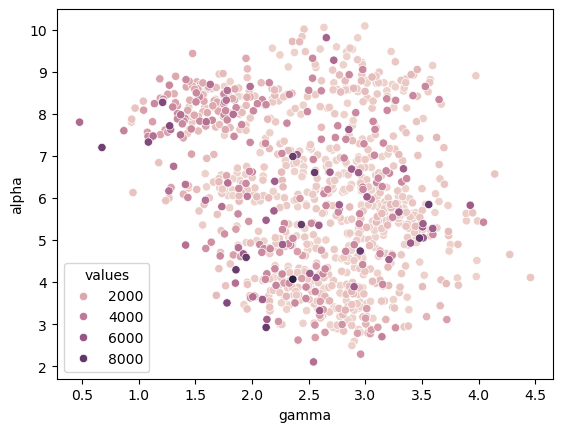

In [68]:
sns.scatterplot(obj_df, x='gamma', y='alpha', hue='values', marker='o')

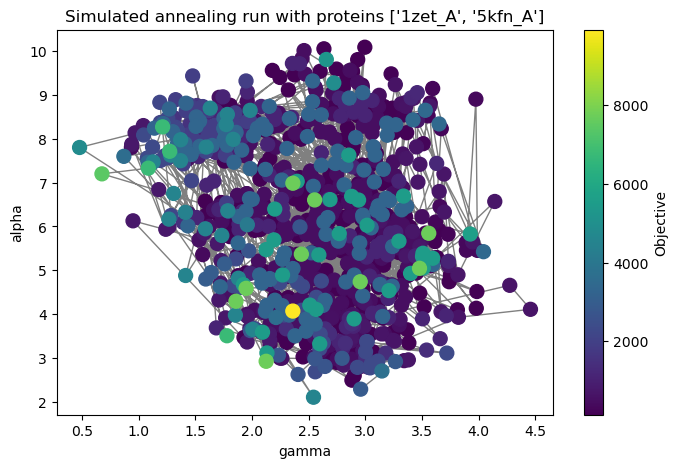

In [69]:
fig, ax = plt.subplots(figsize=(8, 5))
scatter = ax.scatter(obj_df['gamma'], obj_df['alpha'], c=obj_df['values'], cmap="viridis", edgecolor=None, s=100, zorder=2)

# Draw lines connecting the markers
ax.plot(obj_df['gamma'], obj_df['alpha'], color='gray', linestyle='-', linewidth=1, zorder=1)

# Add a colorbar separately
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Objective")

# Labels and title
ax.set_xlabel("gamma")
ax.set_ylabel("alpha")
ax.set_title(f"Simulated annealing run with proteins {sorted_inds}")

plt.show()

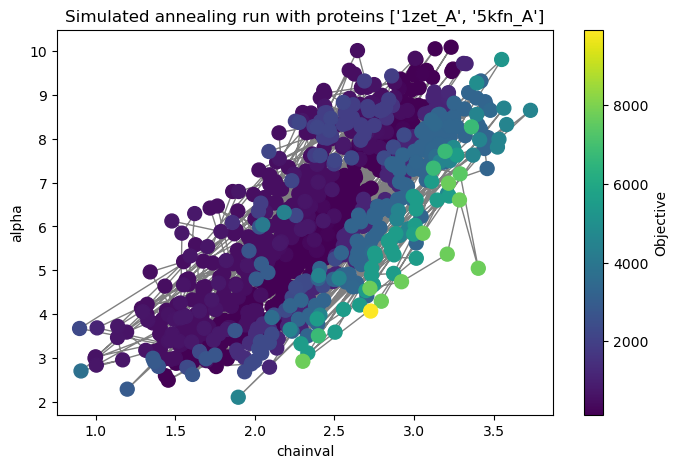

In [70]:
fig, ax = plt.subplots(figsize=(8, 5))
scatter = ax.scatter(obj_df['chainval'], obj_df['alpha'], c=obj_df['values'], cmap="viridis", edgecolor=None, s=100, zorder=2)

# Draw lines connecting the markers
ax.plot(obj_df['chainval'], obj_df['alpha'], color='gray', linestyle='-', linewidth=1, zorder=1)

# Add a colorbar separately
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Objective")

# Labels and title
ax.set_xlabel("chainval")
ax.set_ylabel("alpha")
ax.set_title(f"Simulated annealing run with proteins {sorted_inds}")

plt.show()